In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [56]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [57]:
# import scoring and utility functions from sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_blobs, load_breast_cancer
#
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [58]:
# load the dataset
data = load_breast_cancer()
x = data["data"]
y = data["target"]

In [59]:
# split the data
trainx, testx, trainy, testy = train_test_split(x, y,
                                                random_state=42,
                                                test_size=0.33)

# preprocess the features
scaler = StandardScaler()
trainx = scaler.fit_transform(trainx)
testx = scaler.transform(testx)

# get the shapes
N, D = trainx.shape

In [60]:
# construct the model
model = nn.Sequential(
    nn.Linear(in_features=D, out_features=1),
    nn.Sigmoid()
)

#loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [61]:
# data pytorch tensor conversion
trainx_tensor = torch.from_numpy(trainx.astype("float32"))
testx_tensor = torch.from_numpy(testx.astype("float32"))

trainy_tensor = torch.from_numpy(trainy.astype("float32").reshape(-1, 1))
testy_tensor = torch.from_numpy(testy.astype("float32").reshape(-1, 1))

In [62]:
def get_accuracy(prediction_logits: np.ndarray, targets:np.ndarray):

    # convert logits to labels
    prediction_logits = prediction_logits.copy()
    prediction_logits[prediction_logits >= 0.5] = 1
    prediction_logits[prediction_logits < 0.5] = 0

    # now find out whoch ones are equal
    equals = prediction_logits == targets

    return np.mean(equals)


In [63]:
# start training the model
epochs = 1000
batch_size = 32

# store losses and accuracies
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)

train_accs = np.zeros(epochs)
test_accs = np.zeros(epochs)

for epoch in range(epochs):

    # zero the optimizer
    optimizer.zero_grad()

    # forward pass - then find losses and accuracies
    train_logits = model(trainx_tensor)
    train_loss = criterion(train_logits, trainy_tensor)
    train_acc = get_accuracy(train_logits.detach().numpy(),
                             trainy_tensor.detach().numpy())

    # get the test loss and accuracies
    test_logits = model(testx_tensor)
    test_loss = criterion(test_logits, testy_tensor)
    test_acc = get_accuracy(test_logits.detach().numpy(),
                            testy_tensor.detach().numpy())

    # populate the history arrays
    train_losses[epoch] = train_loss.item()
    test_losses[epoch] = test_loss.item()

    train_accs[epoch] = train_acc
    test_accs[epoch] = test_acc

    # backstep
    train_loss.backward()
    optimizer.step()

    # print info output
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{epochs}---TrainLoss:{train_loss:0.3f}---TrainAcc:{train_acc:0.3f}")
        print(f"\t\t TestLoss:{test_loss:0.3f}---TestAcc:{test_acc:0.3f}")
        print(" = " * 10)


Epoch: 10/1000---TrainLoss:0.722---TrainAcc:0.546
		 TestLoss:0.698---TestAcc:0.590
 =  =  =  =  =  =  =  =  =  = 
Epoch: 20/1000---TrainLoss:0.660---TrainAcc:0.625
		 TestLoss:0.637---TestAcc:0.654
 =  =  =  =  =  =  =  =  =  = 
Epoch: 30/1000---TrainLoss:0.606---TrainAcc:0.714
		 TestLoss:0.585---TestAcc:0.729
 =  =  =  =  =  =  =  =  =  = 
Epoch: 40/1000---TrainLoss:0.559---TrainAcc:0.761
		 TestLoss:0.539---TestAcc:0.755
 =  =  =  =  =  =  =  =  =  = 
Epoch: 50/1000---TrainLoss:0.519---TrainAcc:0.795
		 TestLoss:0.501---TestAcc:0.798
 =  =  =  =  =  =  =  =  =  = 
Epoch: 60/1000---TrainLoss:0.484---TrainAcc:0.829
		 TestLoss:0.467---TestAcc:0.809
 =  =  =  =  =  =  =  =  =  = 
Epoch: 70/1000---TrainLoss:0.453---TrainAcc:0.845
		 TestLoss:0.438---TestAcc:0.846
 =  =  =  =  =  =  =  =  =  = 
Epoch: 80/1000---TrainLoss:0.425---TrainAcc:0.858
		 TestLoss:0.413---TestAcc:0.862
 =  =  =  =  =  =  =  =  =  = 
Epoch: 90/1000---TrainLoss:0.401---TrainAcc:0.877
		 TestLoss:0.390---TestAcc:0.

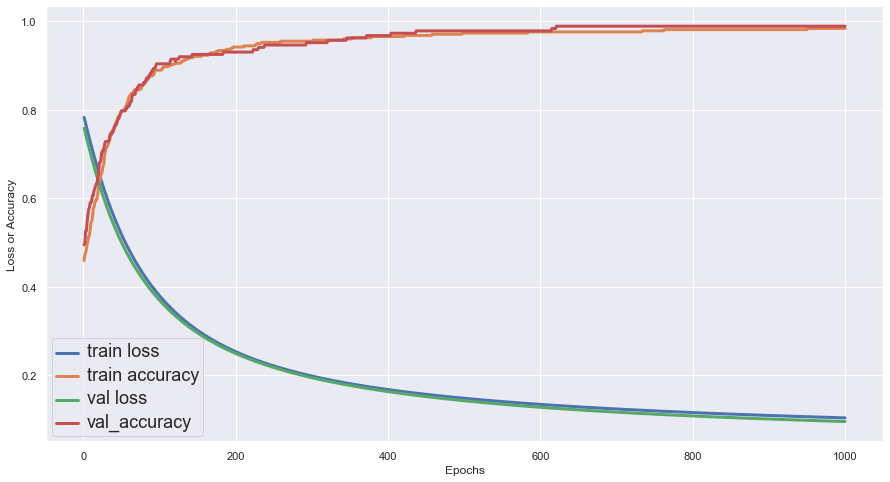

In [64]:
# evaluate the network



# plot the performance
epochs = range(1,epochs+1)
plot_df = pd.DataFrame(data=np.c_[epochs,
                                  train_losses,
                                  train_accs,
                                  test_losses,
                                  test_accs],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [66]:
torch.save(model.state_dict(), "model.pt")